# **Model for Character De-Obfuscation**
Stage 1 of MSc Project — Ashraf Muhammed Yusuf

# **1. Colab Environment Setup**

In [2]:
# Install dependencies
!pip install -q tensorflow matplotlib

# Import dependencies
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from tensorflow.keras import layers, models, callbacks, mixed_precision
from sklearn.metrics import classification_report, confusion_matrix

# Mount Drive so you can read datasets and write checkpoints
# Link to dataset:
# https://drive.google.com/drive/folders/1sfNG1PkmTPBe1wOSQXZmfdkvR97Hn9lk?usp=sharing
drive.mount('/content/drive')

# (Optional—but useful) turn on XLA JIT for extra speed
tf.config.optimizer.set_jit(True)

Mounted at /content/drive


# **2. Data Loading & Splitting**
We'll use Keras's image_dataset_from_directory to build train/validation and test sets.

In [5]:
BATCH = 64
IMG_SIZE = (64, 64)
BASE_DIR="/content/drive/MyDrive/MScProject"
CKPT_DIR=f"{BASE_DIR}/char_ckpt_best.keras"
train_dir = f"{BASE_DIR}/data/characters/train"
test_dir = f"{BASE_DIR}/data/characters/test"

# Train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  labels="inferred",
  label_mode="categorical",
  batch_size=BATCH,
  image_size=IMG_SIZE,
  color_mode="grayscale",
  validation_split=0.20,
  subset="training",
  seed=42
)

# Val dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  labels="inferred",
  label_mode="categorical",
  batch_size=BATCH,
  image_size=IMG_SIZE,
  color_mode="grayscale",
  validation_split=0.20,
  subset="validation",
  seed=42
)

# Test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  labels="inferred",
  label_mode="categorical",
  batch_size=BATCH,
  image_size=IMG_SIZE,
  color_mode="grayscale",
  shuffle=False
)

Found 30700 files belonging to 26 classes.
Using 24560 files for training.
Found 30700 files belonging to 26 classes.
Using 6140 files for validation.
Found 7655 files belonging to 26 classes.


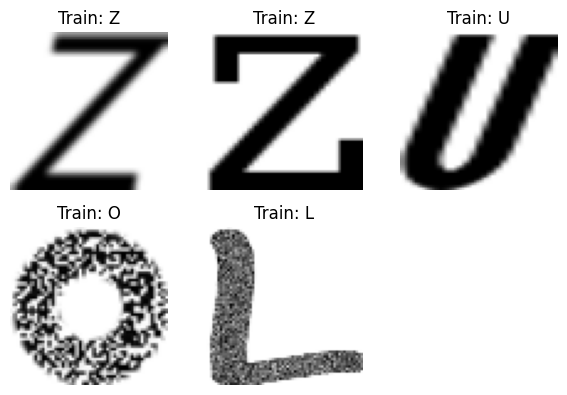

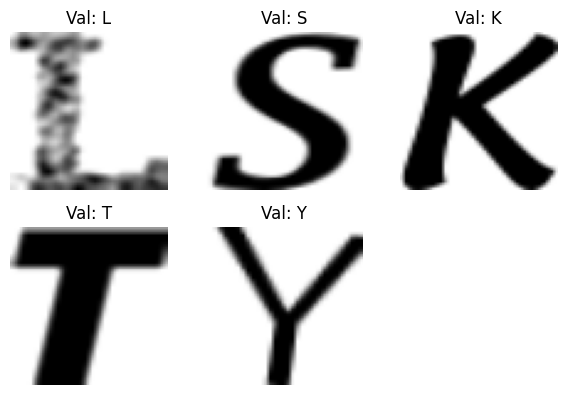

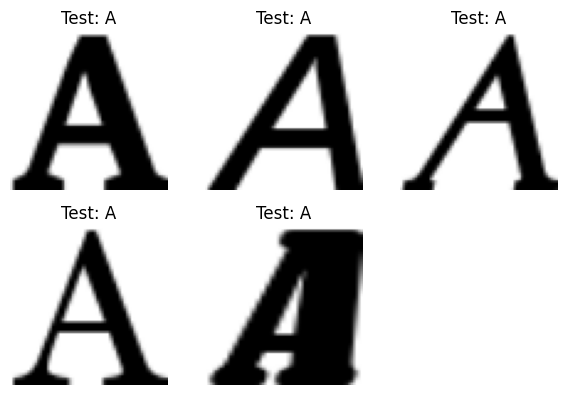

In [6]:
# Utility to display examples from each set
def show_examples(ds, ds_name, num=5):
  # Take one batch
  for images, labels in ds.take(1):
    images = images.numpy()
    labels = labels.numpy()
    class_names = ds.class_names
    break

  plt.figure(figsize=(6,6))
  for i in range(num):
    ax = plt.subplot(3, 3, i+1)
    img = images[i].squeeze()  # shape: (H,W) since grayscale
    lbl = class_names[labels[i].argmax()]
    plt.imshow(img, cmap='gray')
    plt.title(f"{ds_name}: {lbl}")
    plt.axis('off')
  plt.tight_layout()
  plt.show()

# Display 5 examples from each split
show_examples(train_ds, "Train")
show_examples(val_ds, "Val")
show_examples(test_ds, "Test")

# **3. Preprocessing & Augmentation**

In [7]:
# Save dataset class names before piping the dataset through 'map'
train_ds_class_names = test_ds.class_names
val_ds_class_names = test_ds.class_names
test_ds_class_names = test_ds.class_names

# Normalize and augment datasets (only the train dataset is augmented)
normalization = layers.Rescaling(1./255)
aug = tf.keras.Sequential([
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomTranslation(0.1, 0.1)
])

train_ds = train_ds.map(lambda x,y: (aug(normalization(x)), y))
val_ds   = val_ds.map(lambda x,y: (normalization(x), y))
test_ds  = test_ds.map(lambda x,y: (normalization(x), y))

# **4. Model Architecture**
We will define a simple yet robust CNN (grayscale)

In [8]:
# Define model

# 1. Input Layer
inputs = layers.Input(shape=(*IMG_SIZE, 1))

# 2. (Conv + ReLU) + Pooling 1
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPooling2D()(x)

# 3. (Conv + ReLU) + Pooling 2
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)

# 4. (Conv + ReLU)
x = layers.Conv2D(128, 3, activation='relu')(x)

# 5. Flatten to Vector
x = layers.Flatten()(x)

# 6. (FC + ReLU) Layer
x = layers.Dense(128, activation='relu')(x)

# 7. Dropout Regularisation
x = layers.Dropout(0.5)(x)

# 8. Output Layer
outputs = layers.Dense(26, activation='softmax')(x)

# Construct model
model = models.Model(inputs, outputs)

# Show model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,455,450 (9.37 MB)

 Trainable params: 2,455,450 (9.37 MB)

 Non-trainable params: 0 (0.00 B)

# **5. Compilation & Callbacks**

In [9]:
# Compile model
model.compile(
  optimizer=tf.keras.optimizers.Adam(1e-3),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

# Callbacks
# 1. Checkpoint - saves the best model
ckpt = callbacks.ModelCheckpoint(
  filepath=CKPT_DIR,
  save_best_only=True,
  monitor="val_loss" # keep only the best model
)
# 2. Early stopping
es = callbacks.EarlyStopping(
  monitor="val_loss",
  patience=6, # stop ~6 epochs after val_loss stalls
  restore_best_weights=True
)

# 3. LR scheduler
lr_s = callbacks.ReduceLROnPlateau(
  monitor="val_loss",
  factor=0.5,
  patience=3, # halve LR if val_loss hasn’t improved for 3 epochs
  min_lr=1e-6
)

callbacks=[ckpt, es, lr_s]

# **6. Training**

In [10]:
# Train model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50,
  callbacks=callbacks
)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 230s 592ms/step - accuracy: 0.2971 - loss: 2.3982 - val_accuracy: 0.8805 - val_loss: 0.4417 - learning_rate: 0.0010
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 176s 458ms/step - accuracy: 0.6667 - loss: 1.1215 - val_accuracy: 0.9166 - val_loss: 0.3254 - learning_rate: 0.0010
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 177s 461ms/step - accuracy: 0.7319 - loss: 0.8969 - val_accuracy: 0.9192 - val_loss: 0.2888 - learning_rate: 0.0010
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 178s 464ms/step - accuracy: 0.7733 - loss: 0.7578 - val_accuracy: 0.9375 - val_loss: 0.2424 - learning_rate: 0.0010
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 182s 473ms/step - accuracy: 0.7980 - loss: 0.6921 - val_accuracy: 0.9401 - val_loss: 0.2142 - learning_rate: 0.0010
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 176s 458ms/step - accuracy: 0.8097 - loss: 0.6449 - val_accuracy: 0.9454 - val_loss: 0.2009 - learning_rate: 0.0010
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 171s 446ms/step - accura

# **7. Evaluation & Visualisation**

In [ ]:
# Load best checkpoint's weights
model.load_weights(CKPT_DIR)

# Test model accuracy on test dataset
model.evaluate(test_ds)

# Training curves
epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'],    label='train_acc')
plt.plot(epochs, history.history['val_accuracy'],label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'],    label='train_loss')
plt.plot(epochs, history.history['val_loss'],label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# **8. Confusion Matrix & Classification Report**

In [ ]:
# Gather all ground-truths and predictions
y_true = []
y_pred = []
for batch_x, batch_y in test_ds:
  preds = model.predict(batch_x)
  y_pred.extend(np.argmax(preds, axis=1))
  y_true.extend(np.argmax(batch_y.numpy(), axis=1))

class_names = test_ds_class_names
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(train_ds_class_names))
plt.xticks(tick_marks, train_ds_class_names, rotation=90)
plt.yticks(tick_marks, train_ds_class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# **9. Display Misclassified Examples**

In [ ]:
# First flatten all test images to a single array
images_all = np.concatenate([x.numpy() for x, y in test_ds], axis=0)
mis_idx = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t!=p]

plt.figure(figsize=(9, 9))
for i, idx in enumerate(mis_idx[:9]):
  plt.subplot(3, 3, i+1)
  img = images_all[idx].squeeze()
  plt.imshow(img, cmap='gray')
  plt.title(f"T:{class_names[y_true[idx]]} P:{class_names[y_pred[idx]]}")
  plt.axis('off')
plt.tight_layout()
plt.show()